# Machine Learning

Le premier tp porte sur la régression linéaire. La régression linéaire tente d'ajuster une droite de meilleure approximation à un ensemble de données, en utilisant une ou plusieurs caractéristiques comme coefficients d'une équation linéaire. Ici, Nous allons vais discuter :

 - Le chargement, la manipulation et le traçage de données à l'aide de numpy et matplotlib
 - Les fonctions d'hypothèse et de coût pour la régression linéaire
 - La descente de gradient avec une variable et plusieurs variables
 - Mise à l'échelle et normalisation des caractéristiques
 - Vectorisation et équation normale
 - Régression linéaire  dans sk-learn
 - Régression linéaire et descente de gradient dans Tensorflow
 
Nous utilisons comme données d'entainement le jeu de données [UCI Bike Sharing Data Set](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

# Chargement et traçage des données

Pour la première partie, nous allons effectuer une régression linéaire avec une variable, et nous n'utiliserons donc que deux champs de l'ensemble de données quotidiennes : la température maximale normalisée en °C et le nombre total de locations de vélos. Les valeurs des locations sont mises à l'échelle par un facteur de mille, compte tenu de la différence de magnitude entre elles et les températures normalisées.

In [1]:
import pandas as pd

data = pd.read_csv("./data.csv")
display(data)
temps   = data['atemp'].values
rentals = data['cnt'].values / 1000


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Le graphique révèle un certain degré de corrélation entre la température et la location de vélos, comme on pourrait le deviner.

Text(0, 0.5, 'Bike Rentals in 1000s')

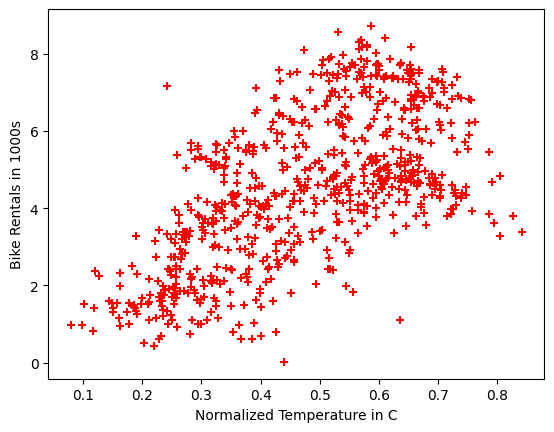

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(temps, rentals, marker='+', color='red')
plt.xlabel('Normalized Temperature in C')
plt.ylabel('Bike Rentals in 1000s')

Analysez la figure et proposez une hypothèse de relation Temperature vs Location de vélos

$h_\theta(x)  = \theta_0 + \theta_1  x$

# Régression linéaire simple

Nous commencerons par implémenter la fonction de coût ([cost function](https://en.wikipedia.org/wiki/Loss_function) ) pour la régression linéaire, plus précisément l'erreur quadratique moyenne ([mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) MSE). Intuitivement, l'erreur quadratique moyenne représente une agrégation des distances entre la valeur y réelle du point et ce qu'une fonction d'hypothèse $h_\theta(x)$ prédit. Cette fonction d'hypothèse et la fonction de coût $J(\theta)$ sont définies comme

\begin{align}
h_\theta(x) & = \theta_0 + \theta_1x_1 \\
J(\theta) & = \frac{1}{2m}\sum\limits_{i = 1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2
\end{align}

où $\theta$ est un vecteur de pondérations de caractéristiques, $x^{(i)}$ est le ième exemple d'apprentissage, $y^{(i)}$ est la valeur y de cet exemple et $x_j$ est la valeur de sa jième caractéristique.

In [3]:
import numpy as np

def compute_cost(X, y, theta):
    return np.sum(np.square(np.matmul(X, theta) - y)) / (2 * len(y))

Avant de calculer le coût avec une estimation initiale de $\theta$, une colonne de 1 est ajoutée aux données d'entrée. Cela nous permet de vectoriser la fonction de coût, ainsi que de la rendre utilisable ultérieurement pour une régression linéaire multiple. Cette première valeur $\theta_0$ se comporte désormais comme une constante dans la fonction de coût.

In [5]:
theta = np.zeros(2)
X = np.column_stack((np.ones(len(temps)), temps))
y = rentals
print(X[:5])
print(y[:5])


[[1.       0.363625]
 [1.       0.353739]
 [1.       0.189405]
 [1.       0.212122]
 [1.       0.22927 ]]
[0.985 0.801 1.349 1.562 1.6  ]


In [6]:

cost = compute_cost(X, y, theta)

print('theta:', theta)
print('cost:', cost)

theta: [0. 0.]
cost: 12.018406441176468


Nous allons maintenant minimiser le coût en utilisant l'algorithme de [descente de gradient](https://en.wikipedia.org/wiki/Gradient_descent). Intuitivement, la descente de gradient prend de petits sauts linéaires le long de la pente d'une fonction dans chaque dimension de caractéristique, la taille de chaque saut étant déterminée par la dérivée partielle de la fonction de coût par rapport à cette caractéristique et un multiplicateur de taux d'apprentissage $\alpha$. Si l'algorithme est correctement réglé, il converge vers un minimum global en ajustant de manière itérative les poids des caractéristiques $\theta$ de la fonction de coût, comme indiqué ici pour deux dimensions de caractéristiques :

\begin{align}
\theta_0 & := \theta_0 - \alpha\frac{\partial}{\partial\theta_0} J(\theta_0,\theta_1) \\
\theta_1 & := \theta_1 - \alpha\frac{\partial}{\partial\theta_1} J(\theta_0,\theta_1)
\end{align}

La règle de mise à jour à chaque itération devient alors :

\begin{align}
\theta_0 & := \theta_0 - \alpha\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)}) \\
\theta_1 & := \theta_1 - \alpha\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_1^{(i)} \\
\end{align}

Voir [ici](http://mccormickml.com/2014/03/04/gradient-descent-derivation/) pour une explication plus détaillée de la manière dont les équations de mise à jour sont dérivées.


In [7]:
def gradient_descent(X, y, alpha, max_iter):
    theta = np.zeros(2)
    m = len(y)
    
    for i in range(max_iter):
        t0 = theta[0] - (alpha / m) * np.sum(np.dot(X, theta) - y)
        t1 = theta[1] - (alpha / m) * np.sum((np.dot(X, theta) - y) * X[:,1])
        theta = np.array([t0, t1])

    return theta


In [9]:

iterations = 5000
alpha = 0.1

theta = gradient_descent(X, y, alpha, iterations)
cost = compute_cost(X, y, theta)

print("theta:", theta)
print('cost:', compute_cost(X, y, theta))

theta: [0.94588081 7.50171673]
cost: 1.1275869258439812


Nous pouvons examiner les valeurs de $\theta$ choisies par l'algorithme à l'aide de quelques visualisations différentes, en traçant d'abord $h_\theta(x)$ par rapport aux données d'entrée. Les résultats montrent la corrélation attendue entre la température et les loyers.

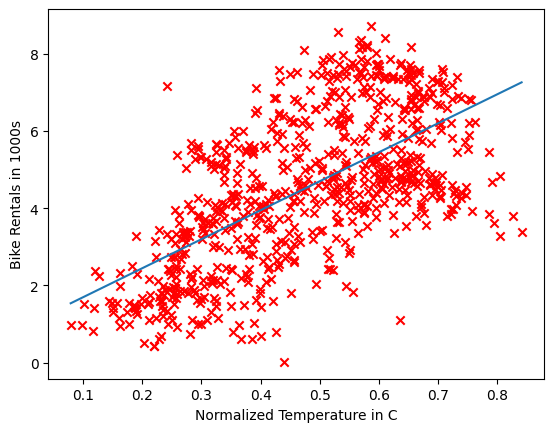

In [10]:
plt.scatter(temps, rentals, marker='x', color='red')
plt.xlabel('Normalized Temperature in C')
plt.ylabel('Bike Rentals in 1000s')
samples = np.linspace(min(temps), max(temps))
plt.plot(samples, theta[0] + theta[1] * samples)

Un tracé de surface est une meilleure illustration de la façon dont la descente de gradient s'approche d'un minimum global, en traçant les valeurs de $\theta$ par rapport à leur coût associé. Cela nécessite un peu plus de code qu'une implémentation dans Octave/MATLAB, en grande partie à cause de la façon dont les données d'entrée sont générées et transmises à la fonction de tracé de surface.

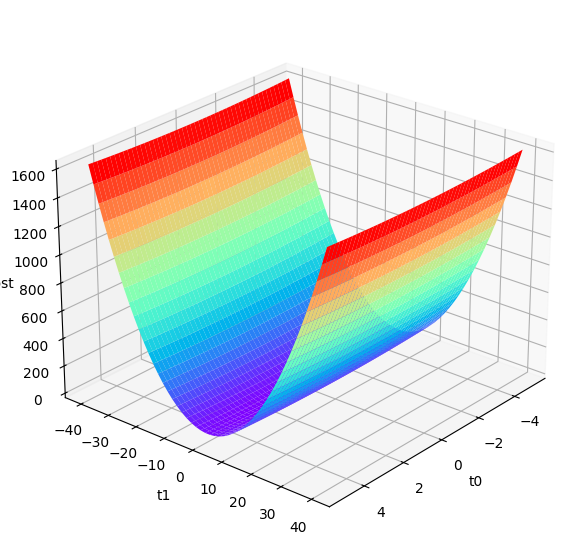

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Xs, Ys = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-40, 40, 50))
Zs = np.array([compute_cost(X, y, [t0, t1]) for t0, t1 in zip(np.ravel(Xs), np.ravel(Ys))])
Zs = np.reshape(Zs, Xs.shape)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel(r't0')
ax.set_ylabel(r't1')
ax.set_zlabel(r'cost')
ax.view_init(elev=25, azim=40)
ax.plot_surface(Xs, Ys, Zs, cmap=cm.rainbow)

Enfin, un tracé de contour révèle des tranches de ce tracé de surface dans l'espace 2D et peut montrer les valeurs $\theta$ résultantes se situant exactement au minimum global.

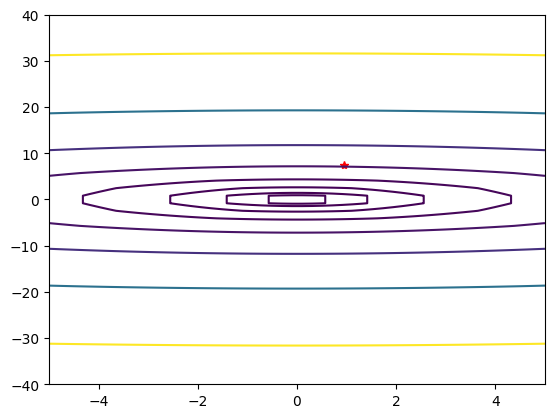

In [15]:
ax = plt.figure().gca()
ax.plot(theta[0], theta[1], 'r*')
plt.contour(Xs, Ys, Zs, np.logspace(-3, 3, 15))

# Régression linéaire Simple par SKlearn

## Sélection des données

- séparer le dataset en training set et test set (X_train, X_test, y_train, y_test)

In [16]:
X = temps
y = rentals
y=y.reshape(len(y), 1)
X=X.reshape(len(X), 1)
print(X.shape)
print(y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1 )

(731, 1)
(731, 1)


 - importer le model lineaire et faire l'apprentissage

In [17]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
 

### Affichage du score R2

 Le R2 score, aussi appelé R-squared ou coefficient de détermination, est l’une des métriques les plus utilisées pour la régression linéaire. Cette métrique est une version “normalisée” de la MSE (Mean Squared Error).
 

 

In [18]:
score = lr.score(X_test, y_test) # renvoie le R2.
print(score)

0.4650953936104534


intercept:  [1.0978946]
coef:  [[7.23122807]]
Score by LR:  0.4650953936104534
R2 score:  0.4650953936104534
theta: [1.0978946  7.23122807]
cost: 53.496031928732485
MSE:  1.5025571201695658


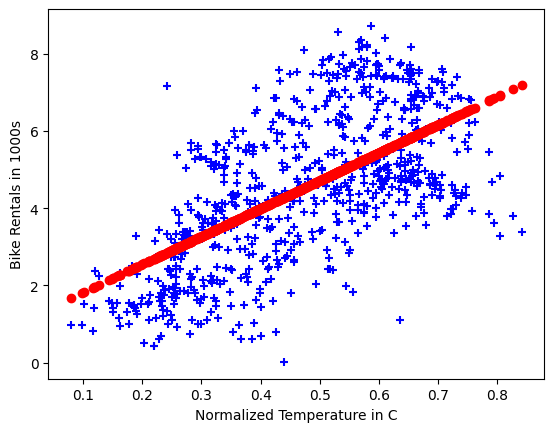

In [19]:
from sklearn import metrics 

y_pred = lr.predict(X)

plt.scatter(X, y, marker='+', color='b')
plt.scatter(X, y_pred, marker='o', color='r')
 
plt.xlabel('Normalized Temperature in C')
plt.ylabel('Bike Rentals in 1000s') 

print ("intercept: " ,lr.intercept_)
print ("coef: ", lr.coef_)
print ("Score by LR: ", score)
print ("R2 score: ", metrics.r2_score(y_test, lr.predict(X_test)))
#https://en.wikipedia.org/wiki/Coefficient_of_determination

theta  =np.hstack( (lr.intercept_ , lr.coef_[0]))   
X = np.column_stack((np.ones(len(temps)), temps))
 
print("theta:", theta)
print('cost:', compute_cost(X, rentals , theta))  
print("MSE: ", np.sqrt(metrics.mean_squared_error(y, y_pred)))

# Régression linéaire multiple 

Tout d'abord, nous rechargeons les données et ajoutons deux autres caractéristiques, l'humidité et la vitesse du vent.

Avant d'implémenter la descente de gradient pour plusieurs variables, nous appliquerons également la [mise à l'échelle des caractéristiques](https://en.wikipedia.org/wiki/Feature_scaling) pour normaliser les valeurs des caractéristiques, empêchant l'une d'entre elles d'influencer de manière disproportionnée les résultats, ainsi que pour aider la descente de gradient à converger plus rapidement. Dans ce cas, chaque valeur de caractéristique est ajustée en soustrayant la moyenne et en divisant le résultat par l'écart type de toutes les valeurs de cette caractéristique :

$$
z = \frac{x - \mu}{\sigma}
$$

Vous trouverez plus de détails sur la mise à l'échelle et la normalisation des caractéristiques [ici](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html).

In [20]:
def feature_normalize(X):
    n_features = X.shape[1]
    means = np.array([np.mean(X[:,i]) for i in range(n_features)])
    stddevs = np.array([np.std(X[:,i]) for i in range(n_features)])
    normalized = (X - means) / stddevs
    
    return normalized

X = data[['atemp', 'hum', 'windspeed']].values
X = feature_normalize(X)
X = np.column_stack((np.ones(len(X)), X))

y = data['cnt'].values / 1000

L'étape suivante consiste à implémenter la descente de gradient pour un nombre quelconque de fonctionnalités. Heureusement, l'étape de mise à jour se généralise facilement et peut être vectorisée pour éviter d'itérer sur les valeurs $\theta_j$ comme cela pourrait être suggéré par l'implémentation à variable unique ci-dessus :
$$
\theta_j := \theta_j - \alpha\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}
$$

In [24]:
# Gradient Descent for Multivariable Linear Regression
def gradient_descent_multi(X, y, theta, alpha, iterations):
    m = len(y)
    
    for i in range(iterations):
        predictions = np.matmul(X, theta)  # Model predictions
        error = predictions - y
        gradient = np.matmul(X.T, error) / m
        theta = theta - alpha * gradient
    
    return theta

# Example usage with mock data
# Let's assume we have 2 features (plus the intercept term)
X = np.array([[1, 1], [1, 2], [1, 3]])  # Add a column for the intercept (1s) if needed
y = np.array([1, 2, 3])
theta = np.zeros(X.shape[1])  # Initialize theta to 0
alpha = 0.1  # Learning rate
iterations = 1000  # Number of iterations

# Perform gradient descent
theta = gradient_descent_multi(X, y, theta, alpha, iterations)

# Calculate the final cost
cost = compute_cost(X, y, theta)

print('theta:', theta)
print('cost:', cost)

theta: [2.06458287e-06 9.99999092e-01]
cost: 0.9999981835779937



Malheureusement, il est désormais plus difficile d'évaluer les résultats visuellement, mais nous pouvons les vérifier avec une méthode totalement différente de calcul de la réponse, l'[équation normale](http://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression/). Cela résout directement la solution sans itération spécifiant une valeur $\alpha$, bien qu'elle commence à être moins performante que la descente de gradient avec un grand nombre (plus de 10 000) de fonctionnalités.

$$
\theta = (X^TX)^{-1}X^Ty
$$

In [25]:
from numpy.linalg import inv

def normal_eq(X, y):
    return inv(X.T.dot(X)).dot(X.T).dot(y)

theta = normal_eq(X, y)
cost = compute_cost(X, y, theta)

print('theta:', theta)
print('cost:', cost)

theta: [-1.77635684e-15  1.00000000e+00]
cost: 1.0


Les valeurs $\theta$ et les coûts de chaque implémentation sont identiques, nous pouvons donc avoir un degré élevé de confiance dans leur exactitude.



# Régression linéaire multiple par SKlearn

Ecrire votre code dans la cellule suivate:


## Régression linéaire dans Tensorflow

Tensorflow propose des abstractions de niveau nettement supérieur avec lesquelles travailler, représentant l'algorithme sous forme de graphique de calcul. Il dispose d'un optimiseur de descente de gradient intégré qui peut minimiser la fonction de coût sans que nous ayons à définir le gradient manuellement.

Nous commencerons par recharger les données et les adapter à des structures de données et à une terminologie plus adaptées à Tensorflow. Les fonctionnalités sont toujours normalisées comme avant, mais la colonne ajoutée de 1 est absente : la constante est traitée séparément comme une variable *biais*, les valeurs $\theta$ précédentes sont désormais des *poids*.

In [ ]:

import tensorflow as tf

X = data[['atemp', 'hum', 'windspeed']].values
X = feature_normalize(X)
y = data['cnt'].values / 1000
y = y.reshape((-1, 1))

m = X.shape[0]
n = X.shape[1]

examples = tf.placeholder(tf.float32, [m,n])
labels = tf.placeholder(tf.float32, [m,1])
weights = tf.Variable(tf.zeros([n,1], dtype=np.float32), name='weight')
bias = tf.Variable(tf.zeros([1], dtype=np.float32), name='bias')

La descente du gradient complète se déroule ci-dessous en seulement trois lignes de code. Il suffit de définir les fonctions d'hypothèse et de coût, puis un optimiseur de descente du gradient pour trouver le minimum.

In [ ]:
hypothesis = tf.add(tf.matmul(examples, weights), bias)
cost = tf.reduce_sum(tf.square(hypothesis - y)) / (2 * m)
optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(cost)

Le graphique est maintenant prêt à être utilisé, et il ne reste plus qu'à démarrer une session, exécuter l'optimiseur de manière itérative et vérifier les résultats.

In [ ]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(1, iterations):
        sess.run(optimizer, feed_dict={
            examples: X,
            labels: y
        }) 
        
    print('bias:', sess.run(bias))
    print('weights:', sess.run(weights))

Les valeurs de biais et de pondération sont identiques aux valeurs $\theta$ calculées dans les deux implémentations précédemment, donc l'implémentation Tensorflow de l'algorithme semble correcte.

You can find the original IPython notebook for this post on [GitHub](https://github.com/crsmithdev/notebooks/blob/master/ml-linear-regression/ml-linear-regression.ipynb).